In [1]:
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
from QWorker import LocalStripedJob
from Q import cosh, sqrt, cos, max_in_group
import math

class DimuonWorker(object):

    def columns(self):
        return ["Muon.pt", "Muon.eta", "Muon.phi", "Muon.q"]

    def init(self, dataset, my_id):

        m = dataset.event.Muon
        m.p = m.pt * cosh(m.eta)

        pair = dataset.event.Muon.pair
        m1, m2 = pair
        pair.M = sqrt(2*m1.pt*m2.pt*(cosh(m1.eta-m2.eta) - cos(m1.phi-m2.phi)))  
        pair.C = m1.q * m2.q
        pair.MaxP = max_in_group(pair.items.p)

    def run(self, events, emit):
        for e in events:
            for pair in e.Muon.pairs.iterate():
                m1, m2 = pair.asTuple()
                if pair.C < 0 and pair.MaxP < 1000:     
                    M = pair.M  
                    if M < 120 and M > 60:
                        emit("mass", M)
                        if M < 92 and M > 88:
                            emit("momentum", m2.p)


        

class DimuonJob(LocalStripedJob):

    def __init__(self, url_head, dataset_name):
        LocalStripedJob.__init__(self, url_head, dataset_name, DimuonWorker)

        self.Masses = []
        self.Momentums = []
    
    def dataReceived(self, wid, key, data, nevents):
        #print "dataReceived(%s, %s)" % (key, data.shape)
        if key == "momentum":   self.Momentums += list(data.reshape((-1,)))
        elif key == "mass":     self.Masses += list(data.reshape((-1,)))

    def initDisplay(self, figure, ipython):
        self.Fig = figure
        self.MassHist = self.Fig.add_subplot(2,1,1,)
        self.MomentumHist = self.Fig.add_subplot(2,1,2)
        self.Bins = 120
        return True     # do animate
        
    def updateDisplay(self, iframe):
    
        if self.Masses:
            self.MassHist.clear()
            self.MassHist.hist(self.Masses, bins=self.Bins)
            self.MassHist.set_title(r"Dimuon mass($\mu^+,\mu^-$)")
        
        if self.Momentums:
            self.MomentumHist.clear()
            self.MomentumHist.hist(self.Momentums, bins=self.Bins)
            if self.Momentums:  self.MomentumHist.set_yscale("log")
            self.MomentumHist.set_title("Muon momentum")

    def jobFinished(self, total_events):
        print "-- Job finished. %d events processed --" % (total_events,)





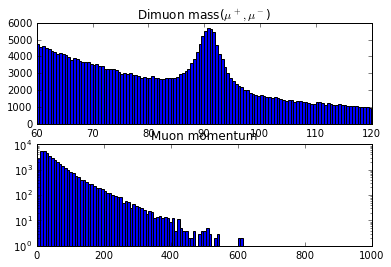

Worker 1 exited with status 0, time=93.397 seconds
-- Job finished. 16923227 events processed --


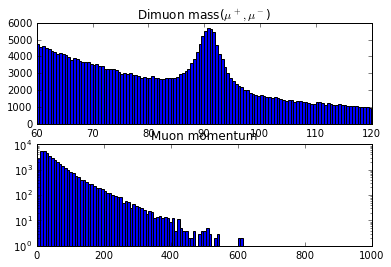

In [3]:
job = DimuonJob("http://dbweb7.fnal.gov:9091/striped/app", "METRun2015D_16Dec2015_v1")
job.start(15)
job.wait()